# QRT Stock Return Prediction

https://challengedata.ens.fr/challenges/23

In [1]:
import os

import lightgbm as lgb
import matplotlib.pyplot as plt
import polars as pl
import polars.selectors as cs
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import ConfusionMatrixDisplay

pl.enable_string_cache()

print("LightGBM version:", lgb.__version__)
print("Polars version  :", pl.__version__)

LightGBM version: 4.6.0
Polars version  : 1.24.0


# Introduction

This notebook is composed of three parts:
1. **data preparation**: We load the data from file and split it into training/validation/test sets.
We build additional features and augment the data to obtain more training examples.
2. **tuning and evaluation**: We train the model and evaluate the result on the validation set. This part dictates the choices for features and hyperparameters.
3. **predictions**: We train the model on all the data and predict the target on the test set.

The notebook can be run in **two modes**: testing and submission.
- In **testing mode**, a test set is withheld from the training data and used to provide an evaluation of the final model.
- In **submission mode**, the actual test data is used to generate the submission file.

# Parameters

We begin by fixing the parameters used throughout the notebook.

In [2]:
# Determines whether to run the notebook in testing or submission mode.
SUBMISSION_MODE = False

In [3]:
DATA_DIR = "data"  # folder containing data files

TARGET = "RET"  # target column

We now set the sampling parameters.

We use a seed when sampling the validation and test sets to ensure reproducibility.
Note that the shape of the validation curve and accuracy scores appearing in the notebook are dependent on the choice of seed, 
so the values obtained here should only be used to determine whether the methodology is correct and not as an estimate of the final score.

In testing mode, the seed determines both the test and the validation sets.
In submission mode, it determines the validation set only, and has no effect on the submission, 
as the submission uses all the data and therefore does not depend on any sampling.

We sample both the test set and the validation set to be one-third of the available training data to mimic the distribution of in the actual data
(~200k test rows to ~400k training rows).

In [4]:
# Seed used when sampling validation and test sets.
SAMPLE_SEED = 0

# Fraction of examples to use as test set.
TEST_FRAC = 0.33

# Fraction of examples (minus test set) to use as validation set.
VALID_FRAC = 0.33

We set the data parameters.
These dictate the feature engineering and data augmenation parts.

There are two window lengths here: one is used for rolling statistics and one is used as input for the model, 
where we only include the most recent time-steps.
Both of these impact the number of available training examples.
The rolling window length reduces the number of available time-steps while the input window length
determines the number of data augmentation steps that we can take (we always take the maximum number).




In [5]:
# Length of the horizontal window used for rolling statistics.
# The rolling statistic at time-step T is the statistic of X_t for T <= t <= T + H_WINDOW_LEN.
# The total number of available time-steps (features) is reduced by ROL_WINDOW_LEN - 1.
ROL_WINDOW_LEN = 5

# Length of the window used as input for the model.
# The model inputs will contain features X_t for 1 <= t <= INPUT_WINDOW_LEN.
# This values also determines the number of data augmentation steps.
# A lower value means more examples (rows) while a higher value means more features (columns).
INPUT_WINDOW_LEN = 2

# Groups over which to take statistics.
GROUPS = ["SECTOR", "INDUSTRY_GROUP"]

# Time-steps for which we compute the rolling statistics.
# These are the only time-steps for which we will have all the features.
# NOTE Not a parameter, do not modify.
AVAILABLE_STEPS = list(range(1, 22 - ROL_WINDOW_LEN))[:20]


print("Available time-steps with rolling statistics:", AVAILABLE_STEPS)
_shifts = len(AVAILABLE_STEPS) - INPUT_WINDOW_LEN + 1
print("->", _shifts, "windows of width", INPUT_WINDOW_LEN)

Available time-steps with rolling statistics: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
-> 15 windows of width 2


# 1 - Data preparation

We beign by reading the data from files.
We store everything in a single `data` dataframe, from which we extract the necessary data when needed.

In [6]:
_x_train = pl.read_csv(os.path.join(DATA_DIR, "x_train.csv"))
_y_train = pl.read_csv(os.path.join(DATA_DIR, "y_train.csv"))

data = _x_train.join(_y_train, on="ID")

if SUBMISSION_MODE:
    _test_data = (
        pl.read_csv(os.path.join(DATA_DIR, "x_test.csv"))
        .with_columns(pl.lit(None).alias(TARGET))
        .select(data.columns)
    )

    data = pl.concat([data, _test_data])

# rename VOLUME_t to VOL_t to make it easier to read when plotting
data = data.rename({f"VOLUME_{t}": f"VOL_{t}" for t in range(1, 21)})

# cast the categorical columns (integers) to pl.Categorical
data = data.with_columns(cs.integer().cast(pl.String).cast(pl.Categorical))

## Data partition

We now sample the training and test sets (in testing mode).
We sample by date to mimic the fact that the actual training and test sets have disjoint dates.

In [7]:
# use maintain_order to ensure reproducibility when sampling
dates = data["DATE"].unique(maintain_order=True)

# in submission mode, use the actual test set
# in testing mode, sample a test set from the training data
test_dates = (
    data.filter(pl.col(TARGET).is_null())["DATE"].unique()
    if SUBMISSION_MODE
    else dates.sample(fraction=TEST_FRAC, seed=SAMPLE_SEED)
)

# sample a validation set
valid_dates = dates.filter(~dates.is_in(test_dates)).sample(
    fraction=VALID_FRAC, seed=SAMPLE_SEED
)

# add a 'set' column indicating which set each entry belongs to
data = data.with_columns(
    set=pl.when(pl.col.DATE.is_in(test_dates))
    .then(pl.lit("test"))
    .when(pl.col.DATE.is_in(valid_dates))
    .then(pl.lit("valid"))
    .otherwise(pl.lit("train"))
)


_mode = "SUBMISSION" if SUBMISSION_MODE else "TESTING"
print("Running in", _mode, "MODE with the following number of rows:")
for set in ("train", "valid", "test"):
    print(f"* {len(data.filter(set=set)):>8,} ({set})")

Running in TESTING MODE with the following number of rows:
*  190,263 (train)
*   90,922 (valid)
*  137,410 (test)


## Feature engineering

We build features from the existing ones by taking statistics over the selected groups.
It is necessary to also aggregate over `DATE` when doing so to avoid mixing data from different days.

We start with rolling statistics.
Here we include `STOCK` in the groups, which corresponds to taking the rolling statistic for individual rows.
We only include rolling variance of returns, not volumes, as these tend to not be significant (determined by testing).

In [8]:
# add rolling mean
data = data.with_columns(
    pl.mean_horizontal(pl.col(f"{var}_{t}") for t in range(step, step + ROL_WINDOW_LEN))
    .over("DATE", group)
    .alias(f"R_G{gp_idx}_mean_{var}_{step}")
    for step in AVAILABLE_STEPS
    for (gp_idx, group) in enumerate(GROUPS + ["STOCK"])
    for var in ("RET", "VOL")
)

# add rolling variance
# NOTE polars does not yet have var_horizontal, so we have to compute it directly
# see https://github.com/pola-rs/polars/issues/9966
data = data.with_columns(
    pl.mean_horizontal(
        (pl.col(f"{var}_{t}") - pl.col(f"R_G{gp_idx}_mean_{var}_{step}")).pow(2)
        for t in range(step, step + ROL_WINDOW_LEN)
    )
    .over("DATE", group)
    .alias(f"R_G{gp_idx}_var_{var}_{step}")
    for step in AVAILABLE_STEPS
    for (gp_idx, group) in enumerate(GROUPS + ["STOCK"])
    for var in ("RET",)
)

Next, we add group statistics for individual days.

In [9]:
data = data.with_columns(
    pl.col(f"{var}_{t}").mean().over("DATE", group).alias(f"G{gp_idx}_mean_{var}_{t}")
    for t in AVAILABLE_STEPS
    for (gp_idx, group) in enumerate(GROUPS)
    for var in ("RET", "VOL")
)

data = data.with_columns(
    pl.col(f"{var}_{t}").var().over("DATE", group).alias(f"G{gp_idx}_var_{var}_{t}")
    for t in AVAILABLE_STEPS
    for (gp_idx, group) in enumerate(GROUPS)
    for var in ("RET", "VOL")
)

## Data augmentation

We now define the functions needed for data augmentation.

To augment the data, we consider successively the values of `RET_t` for each available time-step `t` as target.
We convert `RET_t` to a binary target, select the corresponding input window (all time-steps from `t` to `t + window length`), 
and add the resulting examples to our training data.

Note that we do not perform the data augmentation here since we need to augment different dataframes depending on whether
we are predicting for the validation or test set.
The actual data augmentation is performed on the corresponding set right before training.

In [10]:
# Reorder the columns
#
# It is important that the columns are in this order (numeric last)
# to match the order in which we build the shifted dataframe when augmenting.
data = data.select("set", cs.categorical(), TARGET, cs.numeric())

The next two auxiliary functions are used to select the input window corresponding to a target time-step, and stack such windows together.

In [11]:
def select_window(df: pl.DataFrame, target_t: int, window_len: int) -> pl.DataFrame:
    win_ts = list(range(target_t + 1, target_t + 1 + window_len))  # window time-steps
    win_num_df = df.select(cs.ends_with(f"_{t}") for t in win_ts)  # numeric features

    if target_t == 0:
        return df.select(~cs.numeric(), *win_num_df.columns)

    tar = f"RET_{target_t}"  # new target column

    # replace TARGET with the new target
    new_df = df.with_columns((pl.col(tar) > pl.col(tar).median().over("DATE")))
    new_df = new_df.drop(TARGET)

    # replace the numeric columns with the shifted ones
    new_df = pl.concat([new_df.select(~cs.numeric()), win_num_df], how="horizontal")

    # modify the DATE to include information about the shift
    new_df = new_df.with_columns(pl.col.DATE + f"_t={target_t}")
    new_df = new_df.with_columns(pl.col.DATE.cast(pl.Categorical))

    return new_df

In [12]:
def stack_shifts(df: pl.DataFrame, window_len: int) -> pl.DataFrame:
    # compute the number of shifts, i.e. the max t to use as target
    max_t = len(AVAILABLE_STEPS) - window_len + 1

    # select the first shift (t = 0) separately to get the column names
    dfs = [select_window(df, 0, window_len)]

    for target_t in range(1, max_t):
        win_df = select_window(df, target_t, window_len)
        win_df.columns = dfs[0].columns

        dfs.append(win_df)

    return pl.concat(dfs)

We now define the function used to augment the training data of our dataframes.

The this function will augment the data of the training set as well as the data of the valdation/test set following the steps described above.
Only the shifted targets from the validation/test set (past values) are included in the training examples.

In [13]:
def augment_data(df: pl.DataFrame) -> pl.DataFrame:
    train_df = df.filter(set="train")
    other_df = df.filter(pl.col.set != "train")  # valid or test

    print(
        f"Augmenting dataframe with {len(train_df):,} training rows and {len(other_df):,} non-training rows..."
    )

    # augment the train set
    aug_train_df = stack_shifts(train_df, INPUT_WINDOW_LEN).drop_nulls(TARGET)

    # augment the valid/test set and move new examples from valid/test to train
    aug_other_df = stack_shifts(other_df, INPUT_WINDOW_LEN).drop_nulls(TARGET)
    aug_other_df = aug_other_df[len(other_df) :]  # remove actual target
    aug_other_df = aug_other_df.with_columns(set=pl.lit("train"))

    new_train_len = len(aug_train_df) + len(aug_other_df)
    print(f"Augmented dataframe has {new_train_len:,} training rows.")

    aug_df = pl.concat(
        [aug_train_df, aug_other_df, other_df.select(aug_other_df.columns)]
    )

    return aug_df

## Feature selection

Select the features used by the model.

We only include the rolling statistics at `t = 1` as these are the most relevant to the target time-step.
All other features of the input window are included.

In [14]:
FEATURES = (
    data.select(
        cs.ends_with(f"_{t}") for t in range(1, INPUT_WINDOW_LEN + 1)
    )  # select features corresponding to time-steps in the input window
    .select(
        cs.ends_with("_1") | ~cs.starts_with("R_")
    )  # only keep rolling features at t = 1
    .columns
)

print("Number of selected features:", len(FEATURES))

Number of selected features: 29


# 2 - Tuning and evaluation

In this section, we train and tune the model and evaluate it on the validation set.

We begin by defining a function to compute the predictions (both probabilities and classes), as well as their correctness.

In [15]:
def add_predictions(df: pl.DataFrame, bst: lgb.Booster) -> pl.DataFrame:
    print(f"Computing predictions for {len(df):,} entries.")

    pred = bst.predict(df.select(FEATURES).to_arrow())

    df = df.with_columns(pl.Series("PROBA", pred))
    df = df.with_columns(
        (pl.col("PROBA") > pl.col("PROBA").median().over("DATE")).alias("CLASS")
    )
    df = df.with_columns((pl.col("CLASS") == pl.col(TARGET)).alias("CORRECT"))

    return df

Create a dataframe containing the data to use in this section
This dataframe contains the training and validation sets (no test set), with the training data being augmented.

We also create the LightGBM datasets for both the training and the validation sets.

In [16]:
# Select training + validation sets and augment the data.
vdf = data.filter(pl.col.set != "test")
vdf = augment_data(vdf)

# Construct the LightGBM datasets.
#
# NOTE LightGBM does not yet fully support polars dataframes so we need to convert
# to either arrow or pandas -- we use arrow because it is faster.
# See https://github.com/microsoft/LightGBM/issues/6204
#
# Using arrow does not allow for automatic recognition of categorical features,
# so these need to be passed with the categorical_features parameter if used (or use pandas).

x_train = vdf.filter(set="train").select(FEATURES).to_arrow()
x_valid = vdf.filter(set="valid").select(FEATURES).to_arrow()

y_train = vdf.filter(set="train")[TARGET].to_arrow()
y_valid = vdf.filter(set="valid")[TARGET].to_arrow()

train_set = lgb.Dataset(x_train, label=y_train)
valid_set = lgb.Dataset(x_valid, label=y_valid, reference=train_set)

Augmenting dataframe with 190,263 training rows and 90,922 non-training rows...
Augmented dataframe has 4,090,715 training rows.


## Training

We now set the model parameters and train the model.
The parameters set here will be used both for evaluation on the validation set and for the predictions.

We choose the number of iterations by looking at the point at which the validation loss curve starts plateauing.
Recall that the shape of these curves (especially that of the validation curve) depends heavily on the random sample selected, 
so we should err on the side of caution to avoid over-fitting to the validation set.
For this reason, we choose a number of iterations which may seem too low, but do so with the
hope that it will generalise better than a higher value would.

The rest of the hyperparameters are chosen to reduce over-fitting while keeping the validation curve from being too irregular
and without increasing the overall loss.

In [ ]:
params = dict(
    verbosity=-1,
    objective="binary",
    metric="binary_logloss",
    data_sample_strategy="goss",
    num_iterations=500,
    learning_rate=1e-2,
    extra_trees=True,
    num_leaves=24,
    max_depth=6,
    min_data_in_leaf=100,
    min_gain_to_split=10.0,
)

eval_result = {}

bst = lgb.train(
    params,
    train_set=train_set,
    valid_sets=[train_set, valid_set],
    valid_names=["train", "valid"],
    callbacks=[lgb.record_evaluation(eval_result)],
)

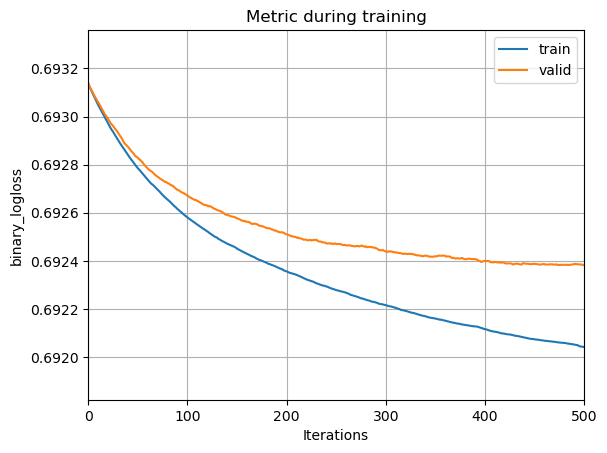

In [18]:
lgb.plot_metric(eval_result)
plt.show()

## Performance evaluation

We evaluate the trained model on the validation set.

This step is particularly important in the model build phase, as it allows us to identify any problems that may arise.
Once the model is working well enough and the parameters are set, it serves to give an idea of how well our model can perform,
and of how well it will generalise by comparing with the test set results (in testing mode).

We do not include any of the steps used for feature selection or hyperparameter tuning in this notebook, 
and instead only evaluate the model with all parameters chosen beforehand.

In [19]:
vdf = add_predictions(vdf, bst)  # compute predictions for training and validation sets

Computing predictions for 4,181,637 entries.


We plot the confusion matrix for both the training and the validation set, including the accuracy.
We see that the predictions are well distributed (no real imbalance between classes) and that the 
accuracy values match what we would expect from the training curves.

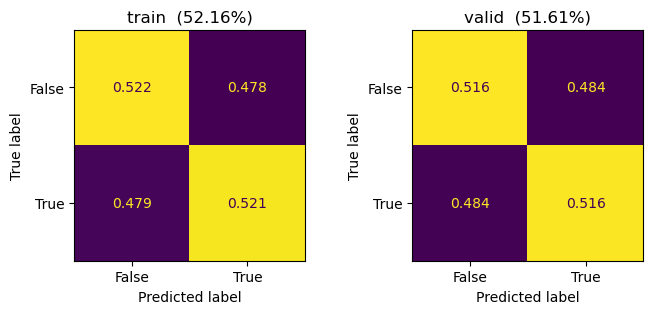

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

for idx, set in enumerate(("train", "valid")):
    acc = 100 * vdf.filter(set=set).select(pl.col.CORRECT.sum() / pl.len()).item()

    ConfusionMatrixDisplay.from_predictions(
        vdf.filter(set=set)[TARGET],
        vdf.filter(set=set)["CLASS"],
        normalize="true",
        values_format=".3f",
        colorbar=False,
        ax=axes[idx],
    ).ax_.set_title(f"{set}  ({acc:.2f}%)")

plt.show()

We also plot the calibration on the two sets. This shows that the model is well-calibrated
It also shows that the predicted probabilities are all very close to 0.5, which indicates that our model predicts with low confidence.

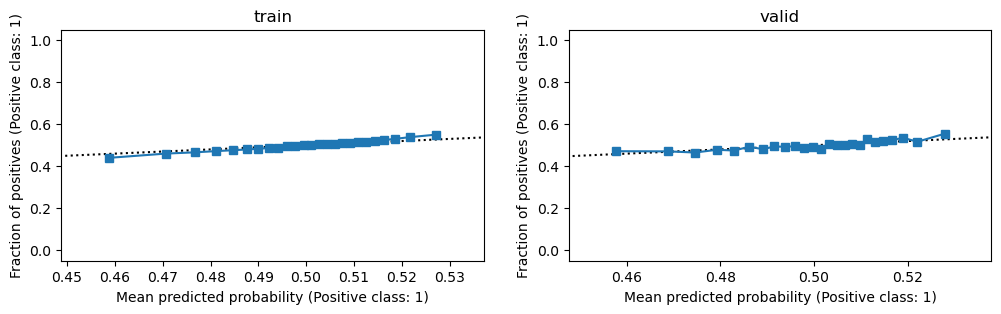

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

for idx, set in enumerate(("train", "valid")):
    cd = CalibrationDisplay.from_predictions(
        vdf.filter(set=set)[TARGET],
        vdf.filter(set=set)["PROBA"],
        strategy="quantile",
        n_bins=25,
        ax=axes[idx],
    )

    cd.ax_.set_xlim([cd.prob_pred.min() - 0.01, cd.prob_pred.max() + 0.01])
    cd.ax_.get_legend().remove()
    cd.ax_.set_title(set)

plt.show()

# 3 - Predictions

Once we are satisfied with the model, we move on to predicting the test set.
For this, we retrain the model on the entire avaliable training data (by merging the training and validation sets) using the parameters fixed above.

In testing mode, we then evaluate the model on the test set to see how well the results from the previous section translate.
In submission mode, we save the predictions to file for submission.

In [22]:
# Merge the training and validation sets and augment the resulting dataframe.
tdf = data.with_columns(set=pl.when(set="valid").then(pl.lit("train")).otherwise("set"))
tdf = augment_data(tdf)

# Train the model on the entire training data.

x_train = tdf.filter(set="train").select(FEATURES).to_arrow()
y_train = tdf.filter(set="train")[TARGET].to_arrow()

train_set = lgb.Dataset(x_train, label=y_train)

print("Training for", params["num_iterations"], "iterations.")

bst = lgb.train(params, train_set=train_set)

# Compute predictions for the test set.
# Drop the training data (no longer needed) to go faster.
tdf = add_predictions(tdf.filter(set="test"), bst)

Augmenting dataframe with 281,185 training rows and 137,410 non-training rows...
Augmented dataframe has 6,101,957 training rows.
Training for 500 iterations.
Computing predictions for 137,410 entries.


In [23]:
if SUBMISSION_MODE:
    tdf.select(
        pl.col.ID.cast(pl.UInt32),
        pl.col("CLASS").alias(TARGET),
    ).write_csv("sub.csv")

    print("Submission saved.")

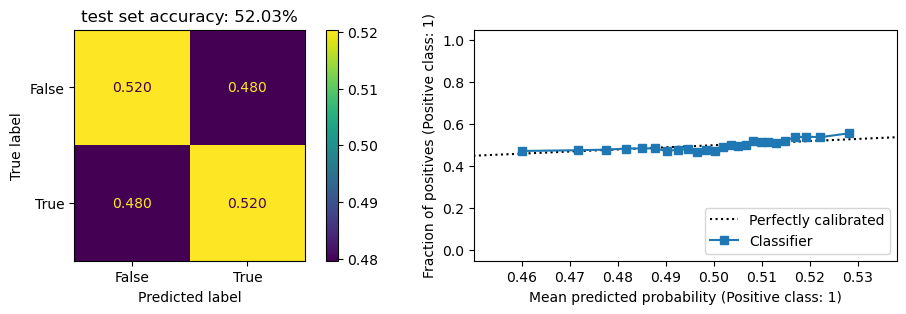

In [24]:
if not SUBMISSION_MODE:
    acc = 100 * tdf.select(pl.col.CORRECT.sum() / pl.len()).item()

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

    cm = ConfusionMatrixDisplay.from_predictions(
        tdf[TARGET],
        tdf["CLASS"],
        normalize="true",
        values_format=".3f",
        ax=axes[0],
    ).ax_.set_title(f"test set accuracy: {acc:.2f}%")

    cd = CalibrationDisplay.from_predictions(
        tdf[TARGET],
        tdf["PROBA"],
        strategy="quantile",
        n_bins=25,
        ax=axes[1],
    )

    cd.ax_.set_xlim([cd.prob_pred.min() - 0.01, cd.prob_pred.max() + 0.01])

    plt.show()

We see that the performance of our model translates well from the validation set to the test set.
This is indicative of the fact that our model is reasonably well tuned, and not over-fitted to the validation set.